# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [1]:
# Add your imports here

import re

import pandas as pd
import numpy as np
import scipy as sp

import platform

#In our team, Windows user need findspark. For Mac findspark can cause problem
if platform.system() == 'Windows':
    import findspark
    findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkFiles

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

DATA_FOLDER = 'data/'

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

In [45]:
#Run only once
data_stack = spark.read.json(DATA_FOLDER + 'Posts.json')
data_stack.write.parquet("data_stack.parquet")

In [2]:
data_stack = spark.read.parquet("data_stack.parquet")

# Convert CreationDate into timestamp
data_stack = data_stack.withColumn("CreationDate", to_timestamp(data_stack['CreationDate'], "yyyy-MM-dd'T'kk:mm:ss.SSSXXX"))

data_stack_rdd = data_stack.rdd

In [58]:
# Determine the structure of the data
data_stack.printSchema()

root
 |-- CreationDate: timestamp (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)



In [129]:
data_stack.show(5)

+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|       CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17 16:20:17|45740344|45740224|         2|    0|                null|                null|     null|
|2017-08-17 16:20:25|45740346|45739185|         2|    1|                null|                null|     null|
|2017-08-17 16:20:28|45740348|    null|         1|    2|<flash><react-nat...|Is it possible to...|      143|
|2017-08-17 16:20:36|45740350|45739102|         2|    1|                null|                null|     null|
|2017-08-17 16:20:46|45740352|42473616|         2|    0|                null|                null|     null|
+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showing top 5 

In [5]:
number__of_question = data_stack_rdd.filter(lambda x : x.PostTypeId == 1).count()
print("The number of question in StackOverflow : {}".format(number__of_question))

The number of question in StackOverflow : 15647060


In [24]:
number__of_answer = data_stack_rdd.filter(lambda x : x.PostTypeId == 2).count()
print("The number of answer in StackOverflow : {}".format(number__of_answer))

The number of answer in StackOverflow : 25192772


In [6]:
number_of_question_score_0 = data_stack_rdd.filter(lambda x : (x.PostTypeId == 1) and (x.Score == 0)).count()
print("The proportion of question with a null score in StackOverflow : {} %"\
      .format(str(number_of_question_score_0 * 100/number__of_question)[:6]))

The proportion of question with a null score in StackOverflow : 46.543 %


### Task A :

First of all, we do the parquet distribution of the entire data and change the type of CreationDate column from string to timestamp to simplify the following step in the homework. 

As we can see, each question in StackOverflow has 1,61 answers in average. But the half of the questions has a null score. It doesn't mean that the question receive any answer but it may show that these questions are not interesting or more trivial for users.  

**Hint:** Load the dataset from the Parquet file for the next tasks.

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

In [78]:
rdd_tags = data_stack_rdd.filter(lambda r: r.Tags != None).flatMap(lambda r: [(x,) for x in (r.Tags[1:-1].split('><'))])

In [81]:
df_tags = pd.DataFrame.from_dict(rdd_tags.countByKey(), orient='index')\
            .rename(index=str, columns={0: "count"}).sort_values('count',ascending=False)
df_tags.head(5)

,count
javascript,1585495
java,1352735
c#,1172492
php,1136082
android,1088811


In [82]:
total_tags = len(df_tags)
df_tags_less_100 = df_tags[df_tags['count'] < 100]
total_tags_less_100 = len(df_tags_less_100)
print('Proportion of tags appearing in fewer than 100 questions : {}%'.
      format(str(total_tags_less_100*100/total_tags)[:5]))

Proportion of tags appearing in fewer than 100 questions : 67.97%


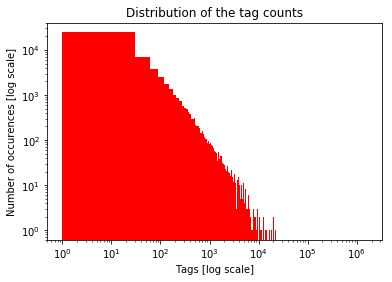

In [83]:
plt.hist(df_tags.values, len(df_tags), log = True, color = 'r');
plt.xscale('log')

plt.title('Distribution of the tag counts');
plt.xlabel('Tags [log scale]');
plt.ylabel('Number of occurences [log scale]');

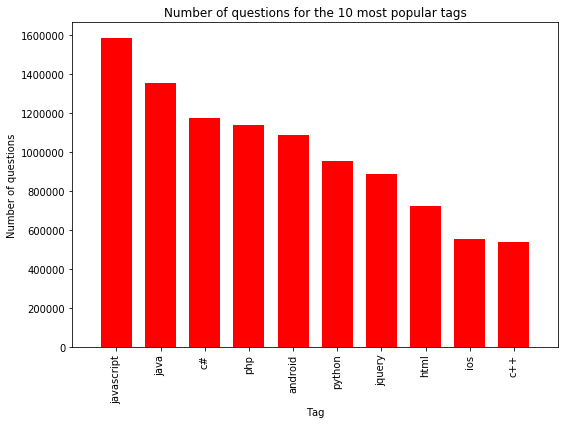

In [84]:
y = df_tags['count'].values[:10]
x = df_tags.index.values[:10]

fig, ax = plt.subplots(figsize=(8, 6))
index = range(len(y))
bar_width = 0.7

ax.bar(index, y, bar_width, color='r')

ax.set_xlabel('Tag')
ax.set_ylabel('Number of questions')
ax.set_title('Number of questions for the 10 most popular tags')
ax.set_xticks(index)
plt.xticks(rotation=90)
ax.set_xticklabels(x)
ax.set_xlim(-1, len(x))
fig.tight_layout()
plt.show()

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

In [ ]:
# Add your code and description here

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


In [4]:
data_stack.registerTempTable('data_stack')

In [26]:
query_python_question = """
select * from data_stack
where Tags like '%<python>%' and CreationDate is not null
"""
python_question_data = spark.sql(query_python_question)
python_question_data.registerTempTable('python_question')
python_question_data.show(3)

+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|       CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17 16:21:08|45740358|    null|         1|    0|<python><websocke...|Python websockets...|      280|
|2017-08-17 16:25:34|45740445|    null|         1|    2|<python><python-2.7>|How to Import Lib...|      146|
|2017-08-17 16:29:45|45740537|    null|         1|   13|<python><pandas><...|Copying MultiInde...|      443|
+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showing top 3 rows



In [27]:
query_java_question = """
select * from data_stack
where Tags like '%<java>%' and CreationDate is not null
"""
java_question_data = spark.sql(query_java_question)
java_question_data.registerTempTable('java_question')
java_question_data.show(3)

+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|       CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17 16:21:57|45740378|    null|         1|    1|<java><android><r...|I getting the fol...|       68|
|2017-08-17 16:23:22|45740406|    null|         1|    0|<java><swing><jta...|two horizontal JT...|       91|
|2017-08-17 16:26:20|45740464|    null|         1|    0|<java><android><a...|can we set custom...|       29|
+-------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showing top 3 rows



In [28]:
answer = """
select CreationDate, ParentId from data_stack
where PostTypeId = 2 and CreationDate is not null
"""
answer_data = spark.sql(answer)
answer_data.registerTempTable('answer')
answer_data.show(3)

+-------------------+--------+
|       CreationDate|ParentId|
+-------------------+--------+
|2017-08-17 16:20:17|45740224|
|2017-08-17 16:20:25|45739185|
|2017-08-17 16:20:36|45739102|
+-------------------+--------+
only showing top 3 rows



In [29]:
answer_min = """
select MIN(CreationDate) as Fisrt_answer, ParentId from answer
group by ParentId
"""
answer_min_data = spark.sql(answer_min)
answer_min_data.registerTempTable('answer_min')
answer_min_data.show(3)

+-------------------+--------+
|       Fisrt_answer|ParentId|
+-------------------+--------+
|2017-08-17 16:40:59|45740555|
|2017-08-17 17:28:52|45739892|
|2017-08-17 18:14:07|45742243|
+-------------------+--------+
only showing top 3 rows



In [30]:
pyhton_fisrt_answer = """
select CreationDate, Tags, Fisrt_answer
from python_question
inner join answer_min on python_question.Id = answer_min.ParentId
"""
pyhton_fisrt_answer_data = spark.sql(pyhton_fisrt_answer)
pyhton_fisrt_answer_data.registerTempTable('pyhton_fisrt_answer')
pyhton_fisrt_answer_data.show(3)

+-------------------+--------------------+-------------------+
|       CreationDate|                Tags|       Fisrt_answer|
+-------------------+--------------------+-------------------+
|2008-09-02 09:40:26| <python><distutils>|2008-09-02 11:43:45|
|2008-09-18 13:41:22|<python><api><soc...|2008-09-18 15:06:11|
|2008-09-22 17:08:12|<python><ms-word>...|2008-09-22 17:16:43|
+-------------------+--------------------+-------------------+
only showing top 3 rows



In [31]:
pyhton_fisrt_answer_data.withColumn("Time_diff",\
                                    pyhton_fisrt_answer_data['Fisrt_answer'] - pyhton_fisrt_answer_data['CreationDate'])

AnalysisException: "cannot resolve '(answer_min.`Fisrt_answer` - python_question.`CreationDate`)' due to data type mismatch: '(answer_min.`Fisrt_answer` - python_question.`CreationDate`)' requires (numeric or calendarinterval) type, not timestamp;;\n'Project [CreationDate#16, Tags#5, Fisrt_answer#485, (Fisrt_answer#485 - CreationDate#16) AS Time_diff#521]\n+- Project [CreationDate#16, Tags#5, Fisrt_answer#485]\n   +- Join Inner, (Id#1L = ParentId#501L)\n      :- SubqueryAlias python_question\n      :  +- Project [CreationDate#16, Id#1L, ParentId#2L, PostTypeId#3L, Score#4L, Tags#5, Title#6, ViewCount#7L]\n      :     +- Filter (Tags#5 LIKE %<python>% && isnotnull(CreationDate#16))\n      :        +- SubqueryAlias data_stack\n      :           +- Project [to_timestamp(CreationDate#0, Some(yyyy-MM-dd'T'kk:mm:ss.SSSXXX)) AS CreationDate#16, Id#1L, ParentId#2L, PostTypeId#3L, Score#4L, Tags#5, Title#6, ViewCount#7L]\n      :              +- Relation[CreationDate#0,Id#1L,ParentId#2L,PostTypeId#3L,Score#4L,Tags#5,Title#6,ViewCount#7L] parquet\n      +- SubqueryAlias answer_min\n         +- Aggregate [ParentId#501L], [min(CreationDate#16) AS Fisrt_answer#485, ParentId#501L]\n            +- SubqueryAlias answer\n               +- Project [CreationDate#16, ParentId#501L]\n                  +- Filter ((PostTypeId#502L = cast(2 as bigint)) && isnotnull(CreationDate#16))\n                     +- SubqueryAlias data_stack\n                        +- Project [to_timestamp(CreationDate#0, Some(yyyy-MM-dd'T'kk:mm:ss.SSSXXX)) AS CreationDate#16, Id#500L, ParentId#501L, PostTypeId#502L, Score#503L, Tags#504, Title#505, ViewCount#506L]\n                           +- Relation[CreationDate#499,Id#500L,ParentId#501L,PostTypeId#502L,Score#503L,Tags#504,Title#505,ViewCount#506L] parquet\n"

In [23]:
pyhton_fisrt_answer_data.drop("CreationDate", "Tags", "Fisrt_answer")

python_time = pyhton_fisrt_answer_data.toPandas()

,CreationDate,Tags,Fisrt_answer
0,2008-09-02 09:40:26,<python><distutils>,2008-09-02 11:43:45
1,2008-09-18 13:41:22,<python><api><sockets><ssl><gmail>,2008-09-18 15:06:11
2,2008-09-22 17:08:12,<python><ms-word><openxml><docx>,2008-09-22 17:16:43
3,2008-10-08 06:34:21,<python><dll><py2exe>,2008-10-08 06:46:57
4,2008-10-22 23:38:30,<python><module>,2008-10-22 23:40:26
5,2009-01-15 15:15:31,<python><database><django><performance>,2009-01-15 15:19:08
6,2009-01-23 11:16:35,<python><iterator><generator>,2009-01-23 11:23:12
7,2009-01-23 20:23:38,<python><unicode><csv><decode><codec>,2009-01-23 20:36:12
8,2009-02-05 14:11:32,<python>,2009-02-05 14:17:39
9,2009-03-06 19:44:12,<python><windows><automation>,2009-03-06 19:53:01


In [20]:
java_fisrt_answer = """
select CreationDate, Tags, Fisrt_answer
from java_question
inner join answer_min on java_question.Id = answer_min.ParentId
"""
java_fisrt_answer_data = spark.sql(pyhton_fisrt_answer)
java_fisrt_answer_data.registerTempTable('pyhton_fisrt_answer')
java_fisrt_answer_data.show(3)

+-------------------+--------------------+-------------------+
|       CreationDate|                Tags|       Fisrt_answer|
+-------------------+--------------------+-------------------+
|2008-09-02 09:40:26| <python><distutils>|2008-09-02 11:43:45|
|2008-09-18 13:41:22|<python><api><soc...|2008-09-18 15:06:11|
|2008-09-22 17:08:12|<python><ms-word>...|2008-09-22 17:16:43|
+-------------------+--------------------+-------------------+
only showing top 3 rows



### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


In [ ]:
# Add your code and description here